# Experiment 04

This Experiment is the main experiment of the work, consists in run an optimized Random Forest in order to try to predict the values in question.(https://www.researchgate.net/publication/221533996_From_an_artificial_neural_network_to_a_stock_market_day-trading_system_A_case_study_on_the_BMF_BOVESPA).

This method consists in using the sliding window 

In [1]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

### Constants and Parameters

In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5

In [33]:
TEST_BEGIN = '2020.06.01'
TEST_END = '2021.06.01'

WINDOW = 1000
DRIFT = 10

TIMES = 1

def safeDate(df, begin, period):
    index = df[df['date'] == begin].index[0]
    
    newIndex = index - (period+2)
    newDate = df[df.index == newIndex].date
    
    return newDate.iloc[0]

### Opening the dataset

In [34]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

beginDate = safeDate(df, TEST_BEGIN, WINDOW)

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")
df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

In [35]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

In [36]:
initialDf_PETR4 = getPeriod(df, beginDate ,TEST_END, True)
initialDf_VALE3 = getPeriod(df2,beginDate,TEST_END, True)

In [17]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.07.25,11.80,12.02,11.80,11.99,11.767548,11.898038,11.668546,11.794237,12.109500,...,11.82,11.88,11.79,12.04,11.76,12.00,11.79,11.81,11.64,11.74
1,2017.07.26,12.06,12.10,11.77,11.77,11.865032,11.965359,11.702364,11.786158,12.232253,...,11.49,11.51,12.05,12.11,11.82,11.88,11.79,12.04,11.76,12.00
2,2017.07.27,11.84,11.94,11.79,11.79,11.856688,11.956906,11.731576,11.787439,12.128523,...,11.58,11.68,11.79,11.83,11.49,11.51,12.05,12.11,11.82,11.88
3,2017.07.28,11.77,11.91,11.71,11.91,11.827792,11.941271,11.724384,11.828293,12.127418,...,11.80,11.99,11.64,11.72,11.58,11.68,11.79,11.83,11.49,11.51
4,2017.07.31,11.99,12.07,11.85,12.05,11.881861,11.984180,11.766256,11.902195,12.144745,...,11.77,11.77,11.80,12.02,11.80,11.99,11.64,11.72,11.58,11.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
947,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
948,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
949,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [18]:
initialDf_VALE3

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.07.25,25.86,26.82,25.86,26.78,25.642986,26.149633,25.407715,25.909778,26.805159,...,25.07,25.13,26.26,26.40,26.01,26.16,26.16,26.28,25.83,26.16
1,2017.07.26,27.04,27.04,25.94,25.95,26.108657,26.446422,25.585143,25.923185,27.467193,...,24.78,24.94,26.10,26.10,25.07,25.13,26.26,26.40,26.01,26.16
2,2017.07.27,25.95,26.43,25.61,25.99,26.055772,26.440948,25.593429,25.945457,27.417838,...,24.94,25.49,25.11,25.41,24.78,24.94,26.10,26.10,25.07,25.13
3,2017.07.28,25.84,26.56,25.66,26.55,25.983848,26.480632,25.615619,26.146971,27.372997,...,25.86,26.78,25.04,25.51,24.94,25.49,25.11,25.41,24.78,24.94
4,2017.07.31,27.56,27.58,27.16,27.39,26.509232,26.847088,26.130413,26.561314,28.046997,...,25.94,25.95,25.86,26.82,25.86,26.78,25.04,25.51,24.94,25.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2021.05.26,106.37,110.32,106.03,110.20,109.166674,111.131617,107.622606,109.807900,113.973861,...,108.50,109.40,111.70,112.10,110.20,111.11,112.10,112.78,109.84,112.25
947,2021.05.27,110.80,112.09,109.77,110.99,109.711116,111.451078,108.338404,110.201933,113.405981,...,107.51,109.78,111.11,111.25,108.50,109.40,111.70,112.10,110.20,111.11
948,2021.05.28,111.11,112.75,109.42,111.59,110.177411,111.884052,108.698936,110.664622,113.405981,...,106.78,107.05,108.00,110.14,107.51,109.78,111.11,111.25,108.50,109.40
949,2021.05.31,112.50,114.89,112.50,114.78,110.951607,112.886035,109.965957,112.036415,114.811204,...,106.03,110.20,110.28,110.89,106.78,107.05,108.00,110.14,107.51,109.78


#### Experimento 04: Utilizando Random Forest

In [112]:
def getTrainPeriod(df, begin, period):
    
    index = df[df['date'] == begin].index[0]
    index = index-1
    
    endDate = df[df.index == index].date
    beginDate = df[df.index == (index-period)].date
    
    return beginDate.iloc[0], endDate.iloc[0]
    

def exp04(df, stock, inputColumns = []):
    
    beginTrain, endTrain = getTrainPeriod(df,TEST_BEGIN, WINDOW)
    
    df_test_aux = getPeriod(df, TEST_BEGIN, TEST_END)
    
    indexBegin = df_test_aux.head(1).index[0]
    indexEnd = df_test_aux.tail(1).index[0]
    
    for i in range (indexBegin, indexEnd, DRIFT):
        
        df_test = df[(df.index >= i) & (df.index <= i+DRIFT-1)]
        df_train = df[(df.index >= i-WINDOW) & (df.index < i)]
    
        if(inputColumns == []):
            x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
            y_train = df_train[['high','low']]

            x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
            y_test = df_test[['high','low']]
        else:
            x_train = df_train[inputColumns]
            y_train = df_train[['high','low']]

            x_test = df_test[inputColumns]
            y_test = df_test[['high','low']]

        rf = RandomForestRegressor(n_estimators = 500)

        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        #print('train: ' + df_train['date'].head(1).tolist()[0] + ' - ' + df_train['date'].tail(1).tolist()[0])
        #print('_test: ' + df_test['date'].head(1).tolist()[0] + ' - ' + df_test['date'].tail(1).tolist()[0])
        #printResult(mape(y_test['high'],y_pred[:,0]), 'High')
        #printResult(mape(y_test['low'],y_pred[:,1]), 'Low')
        #print('###')
        
        if(i == indexBegin):
            max_test = np.array(y_test['high'])
            min_test = np.array(y_test['low'])
            max_pred = np.array(y_pred[:,0])
            min_pred = np.array(y_pred[:,1])
        else:
            max_test = np.append(max_test, np.array(y_test['high']))
            min_test = np.append(min_test, np.array(y_test['low']))
            max_pred = np.append(max_pred, np.array(y_pred[:,0]))
            min_pred = np.append(min_pred, np.array(y_pred[:,1]))
    
        #errorMax = mape(predDf['high'],predDf['high_pred'])
        #errorMin = mape(predDf['low'],predDf['low_pred'])
    
    return max_test, min_test, max_pred, min_pred

def test30timesExp04(df,stock, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    accMax_test = []
    accMin_test = []
    accMax_pred = []
    accMin_pred = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            max_test, min_test, max_pred, min_pred = exp04(df, stock)
        else: 
            max_test, min_test, max_pred, min_pred = exp04(df, stock, columnInput)
    
        accMax_test = np.append(accMax_test,max_test)
        accMin_test = np.append(accMin_test,min_test)
        
        accMax_pred = np.append(accMax_pred,max_pred)
        accMin_pred = np.append(accMin_pred,min_pred)
    
    print(phrase)
    printResult(mape(accMax_test,accMax_pred), 'High')
    printResult(mape(accMin_test,accMin_pred), 'Low')
    
    return mape(accMax_test,accMax_pred), mape(accMin_test,accMin_pred)

In [10]:
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25) 
test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')  

PETR4 15 Variables
High: 1.2 +- 0.98 %
Low: 1.22 +- 1.06 %
PETR4 25 Variables
High: 1.23 +- 1.01 %
Low: 1.26 +- 1.1 %
PETR4 33 Variables
High: 1.21 +- 1.01 %
Low: 1.26 +- 1.14 %


VALE3 15 Variables
High: 2.34 +- 2.82 %
Low: 2.42 +- 2.68 %
VALE3 25 Variables
High: 2.38 +- 2.82 %
Low: 2.45 +- 2.72 %
VALE3 33 Variables
High: 2.4 +- 2.79 %
Low: 2.47 +- 2.69 %


In [113]:
acc_aux_max = []
acc_aux_min = []
labels = []

for x in range (100,1001,100):
    WINDOW = x
    TIMES = 1
    print(str(WINDOW)+' #################')
    aux_max, aux_min = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
    #aux_max, aux_min = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
    labels.append(str(x))
    acc_aux_max.append(aux_max)
    acc_aux_min.append(aux_min)

100 #################
PETR4 15 Variables
High: 2.24 +- 2.41 %
Low: 2.23 +- 2.75 %
200 #################
PETR4 15 Variables
High: 1.71 +- 1.7 %
Low: 1.79 +- 2.18 %
300 #################
PETR4 15 Variables
High: 1.37 +- 1.32 %
Low: 1.34 +- 1.5 %
400 #################
PETR4 15 Variables
High: 1.2 +- 0.97 %
Low: 1.21 +- 1.05 %
500 #################
PETR4 15 Variables
High: 1.1 +- 0.86 %
Low: 1.07 +- 0.97 %
600 #################
PETR4 15 Variables
High: 1.1 +- 0.87 %
Low: 1.02 +- 0.89 %
700 #################
PETR4 15 Variables
High: 1.04 +- 0.89 %
Low: 1.01 +- 0.9 %
800 #################
PETR4 15 Variables
High: 1.02 +- 0.89 %
Low: 1.03 +- 0.92 %
900 #################
PETR4 15 Variables
High: 1.04 +- 0.88 %
Low: 1.02 +- 0.9 %
1000 #################
PETR4 15 Variables
High: 1.05 +- 0.87 %
Low: 1.03 +- 0.91 %


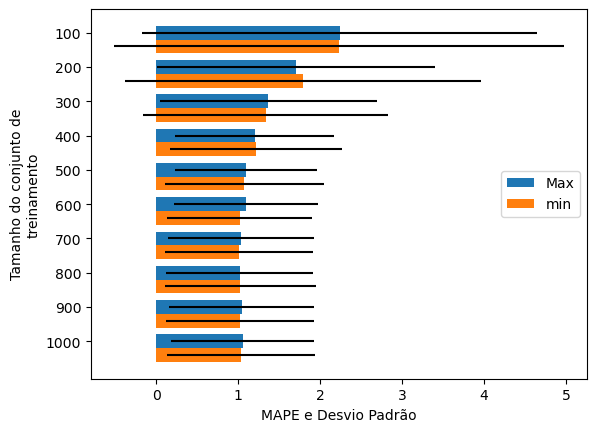

<Figure size 640x480 with 0 Axes>

In [114]:
max_error,max_std = zip(*acc_aux_max) 
min_error,min_std = zip(*acc_aux_min) 
width = 0.4

estimators = labels
y_pos = np.arange(len(estimators))
plt.rcdefaults()
fig, ax = plt.subplots()

estimators = labels
y_pos = np.arange(len(estimators))

a = ax.barh(y_pos, max_error, width, xerr=max_std, align='center')
b = ax.barh(y_pos+width, min_error, width, xerr=min_std, align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, minor=False)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('MAPE e Desvio Padrão')
ax.set_ylabel('Tamanho do conjunto de\ntreinamento')
#ax.set_title('PETR4')
ax.legend((a[0], b[0]), ['Max', 'min'], loc='center right')

plt.show()
plt.clf()

100 #################
VALE3 15 Variables
High: 2.38 +- 2.81 %
Low: 2.44 +- 2.68 %
200 #################
VALE3 15 Variables
High: 2.34 +- 2.81 %
Low: 2.38 +- 2.69 %
300 #################
VALE3 15 Variables
High: 2.34 +- 2.8 %
Low: 2.38 +- 2.7 %
400 #################
VALE3 15 Variables
High: 2.33 +- 2.81 %
Low: 2.41 +- 2.69 %
500 #################
VALE3 15 Variables
High: 2.24 +- 2.77 %
Low: 2.34 +- 2.67 %
600 #################
VALE3 15 Variables
High: 2.24 +- 2.77 %
Low: 2.34 +- 2.67 %
700 #################
VALE3 15 Variables
High: 2.24 +- 2.77 %
Low: 2.35 +- 2.67 %
800 #################
VALE3 15 Variables
High: 2.23 +- 2.77 %
Low: 2.34 +- 2.68 %
900 #################
VALE3 15 Variables
High: 2.24 +- 2.78 %
Low: 2.34 +- 2.67 %
1000 #################
VALE3 15 Variables
High: 2.23 +- 2.77 %
Low: 2.34 +- 2.66 %


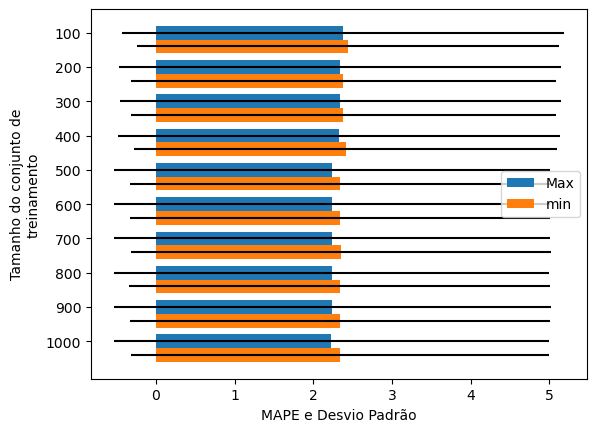

<Figure size 640x480 with 0 Axes>

In [115]:
acc_aux_max = []
acc_aux_min = []
labels = []

for x in range (100,1001,100):
    WINDOW = x
    TIMES = 1
    print(str(WINDOW)+' #################')
    #aux_max, aux_min = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
    aux_max, aux_min = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
    labels.append(str(x))
    acc_aux_max.append(aux_max)
    acc_aux_min.append(aux_min)

max_error,max_std = zip(*acc_aux_max) 
min_error,min_std = zip(*acc_aux_min) 
width = 0.4

estimators = labels
y_pos = np.arange(len(estimators))
plt.rcdefaults()
fig, ax = plt.subplots()

estimators = labels
y_pos = np.arange(len(estimators))

a = ax.barh(y_pos, max_error, width, xerr=max_std, align='center')
b = ax.barh(y_pos+width, min_error, width, xerr=min_std, align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, minor=False)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('MAPE e Desvio Padrão')
ax.set_ylabel('Tamanho do conjunto de\ntreinamento')
#ax.set_title('VALE3')
ax.legend((a[0], b[0]), ['Max', 'min'], loc='center right')

plt.show()
plt.clf()